In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from geomappy.colors import cmap_from_borders

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import SymLogNorm, Normalize
import matplotlib.patches as patches
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.max_rows', 200)

/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def calc_r2(y, y_predict):
    mask = ~np.logical_or(np.isnan(y), np.isnan(y_predict))
    return r2_score(y[mask], y_predict[mask])


def calc_r(y, y_predict, num=1000):
    mask = ~np.logical_or(np.isnan(y), np.isnan(y_predict))
    y = np.asarray(y[mask])
    y_predict = np.asarray(y_predict[mask])

    samples = np.empty(num)
    for i in range(num):
        idx = np.random.choice(np.arange(y.size), y.size, replace=True)
        d1 = y[idx]
        d2 = y_predict[idx]
        samples[i] = pearsonr(d1, d2)[0]

    return pearsonr(y, y_predict)[0], np.nanstd(samples)

## Loading data

In [3]:
df = pd.read_csv("data/processed_data/df_hm_included.csv", index_col=0)
df_locations = gpd.read_file("data/processed_data/df_locations.geojson")
translations = pd.read_excel("data/translation_items.xlsx", index_col=0)

FIRST_ITEM = "plastic_6_packringen"
LAST_ITEM = "granulaat_korrels"
ind_item = [list(df.columns).index(x) for x in [FIRST_ITEM, LAST_ITEM]]
s_items = slice(ind_item[0], ind_item[1], None)

ITEMS = [item for item in list(df.columns)[s_items]]

df.loc[:, 'sampling'] = df.Gebiedscode.apply(lambda x: 'Reference' if "REFE" in x else 'Volunteer')
df.loc[:, 'river'] = df.Gebiedscode.apply(lambda x: x[0])
df = df.loc[df.river.isin(["W", "M"])]
df.loc[:, 'all'] = df.loc[:, ITEMS].sum(axis=1)
df.loc[:, 'season'] = df.meting.apply(lambda x: "Autumn" if x in [0,2] else "Spring")
df = df.loc[df.date != 0, :]

Calculate time since last observation at a single location. If no previous measurements are made the value is NaN.

In [4]:
df.date = pd.to_datetime(df.date, format="%Y%m%d")
df.loc[:, 'time_after_last'] = np.nan

for i, row in df.iterrows():
    date_differences = (row.date - df.loc[df.Gebiedscode == row.Gebiedscode, 'date']).dt.days
    previous_dates = date_differences[date_differences > 0]
    if previous_dates.size == 0:
        df.time_after_last.loc[i] = np.nan
    else:
        df.time_after_last.loc[i] = previous_dates.min()

/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
parameters = ["P", "U", "Q", "dop", "time_after_last", "season", "river", "sampling"]
lags = ["2d", "7d", "14d", "1m", "6m"]

titles = {"P": "Precipitation",
          "U": "Wind speed",
          "Q": "Water height",
          "dop": "Time",
          "time_after_last": "Time after last observation",
          "season": "Seasonality",
          "river": "Waal vs Meuse",
          "sampling": "Volunteer vs Reference"}

In [6]:
precipitation_r2 = pd.DataFrame(index=ITEMS, columns=lags, dtype='float')
wind_r2 = pd.DataFrame(index=ITEMS, columns=lags, dtype='float')
discharge_r2 = pd.DataFrame(index=ITEMS, columns=lags, dtype='float')

single_param_r2 = pd.DataFrame(index=ITEMS, columns=parameters, dtype='float')
performance = pd.DataFrame(index=ITEMS, columns=parameters, dtype='float')

multi_param_r2 = pd.DataFrame(index=ITEMS, columns=['r2'], dtype='float')
multi_param_r = pd.DataFrame(index=ITEMS, columns=['r', 'std'], dtype='float')
coefficient = pd.DataFrame(index=ITEMS, columns=parameters, dtype='float')

## Modelling

### Single-parameter models

optimal time-lag

In [7]:
for lag in lags:
    print(lag, end="\t")
    for item in ITEMS:
        formula = f'{item} ~ P_{lag}_max'
        model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(full_output=True)
        precipitation_r2.loc[item, lag] = calc_r2(df[item], model.predict(df))
        
        formula = f'{item} ~ U_{lag}_max'
        model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(full_output=True)
        wind_r2.loc[item, lag] = calc_r2(df[item], model.predict(df))
        
        formula = f'{item} ~ h_{lag}_max_above_current'
        model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(full_output=True)
        discharge_r2.loc[item, lag] = calc_r2(df[item], model.predict(df))

2d	

/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:1223: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:1223: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)


7d	14d	1m	6m	

In [8]:
precipitation_lag = precipitation_r2.idxmax(axis=1)
wind_lag = wind_r2.idxmax(axis=1)
discharge_lag = discharge_r2.idxmax(axis=1)

In [9]:
for parameter in parameters:
    print(parameter, end="\t")
    col = parameter
    for item in ITEMS:
        if parameter in ['season', 'river', 'sampling']:
            formula = f'{item} ~ C({parameter})'
        elif parameter == "P":
            parameter = f'P_{precipitation_lag[item]}_max'
            formula = f'{item} ~ {parameter}'
        elif parameter == "U":
            parameter = f'U_{wind_lag[item]}_max'
            formula = f'{item} ~ {parameter}'
        elif parameter == "Q":
            parameter = f'h_{discharge_lag[item]}_max_above_current'
            formula = f'{item} ~ {parameter}'
        else:
            formula = f'{item} ~ {parameter}'

        try:
            model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(full_output=True)
        except (ValueError, statsmodels.tools.sm_exceptions.PerfectSeparationError):
            continue

        if parameter == 'river':
            select = "C(river)[T.W]"
        elif parameter == 'sampling':
            select = "C(sampling)[T.Volunteer]"
        elif parameter == 'season':
            select = "C(season)[T.Spring]"
        else:
            select = parameter

        true_r2 = calc_r2(df.loc[:, item], model.predict(df))
        random_r2 = pd.read_csv(f"data/item_variance/{parameter}_{item}.csv", index_col=0).iloc[:, 0]

        single_param_r2.loc[item, col] = true_r2
        performance.loc[item, col] = (random_r2 < true_r2).sum()/1000

P	U	Q	dop	time_after_last	

/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:521: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:1223: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:1223: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:1227: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self

season	river	sampling	

### Multi-parameter models

In [10]:
for item in ITEMS:
    formula = f'{item} ~ P_{precipitation_lag[item]}_max + U_{wind_lag[item]}_max + h_{discharge_lag[item]}_max_above_current + dop + time_after_last + C(season) + C(river) + C(sampling)'
    try:
        model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(full_output=True)
    except (ValueError, statsmodels.tools.sm_exceptions.PerfectSeparationError):
        continue

    select = [f"P_{precipitation_lag[item]}_max", f"U_{wind_lag[item]}_max", f"h_{discharge_lag[item]}_max_above_current",
              "dop", "time_after_last", "C(season)[T.Spring]", "C(river)[T.W]", "C(sampling)[T.Volunteer]"]

    multi_param_r2.loc[item] = calc_r2(df.loc[:, item], model.predict(df))
    multi_param_r.loc[item] = calc_r(df.loc[:, item], model.predict(df))
    coefficient.loc[item] = model.params[select].values

/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:1223: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/thesis/lib/pyt

## Figures

### Table plot

In [11]:
x = single_param_r2 * np.sign(coefficient)
x[performance < 0.9] = np.nan
x['name'] = translations.loc[x.index, 'Name']

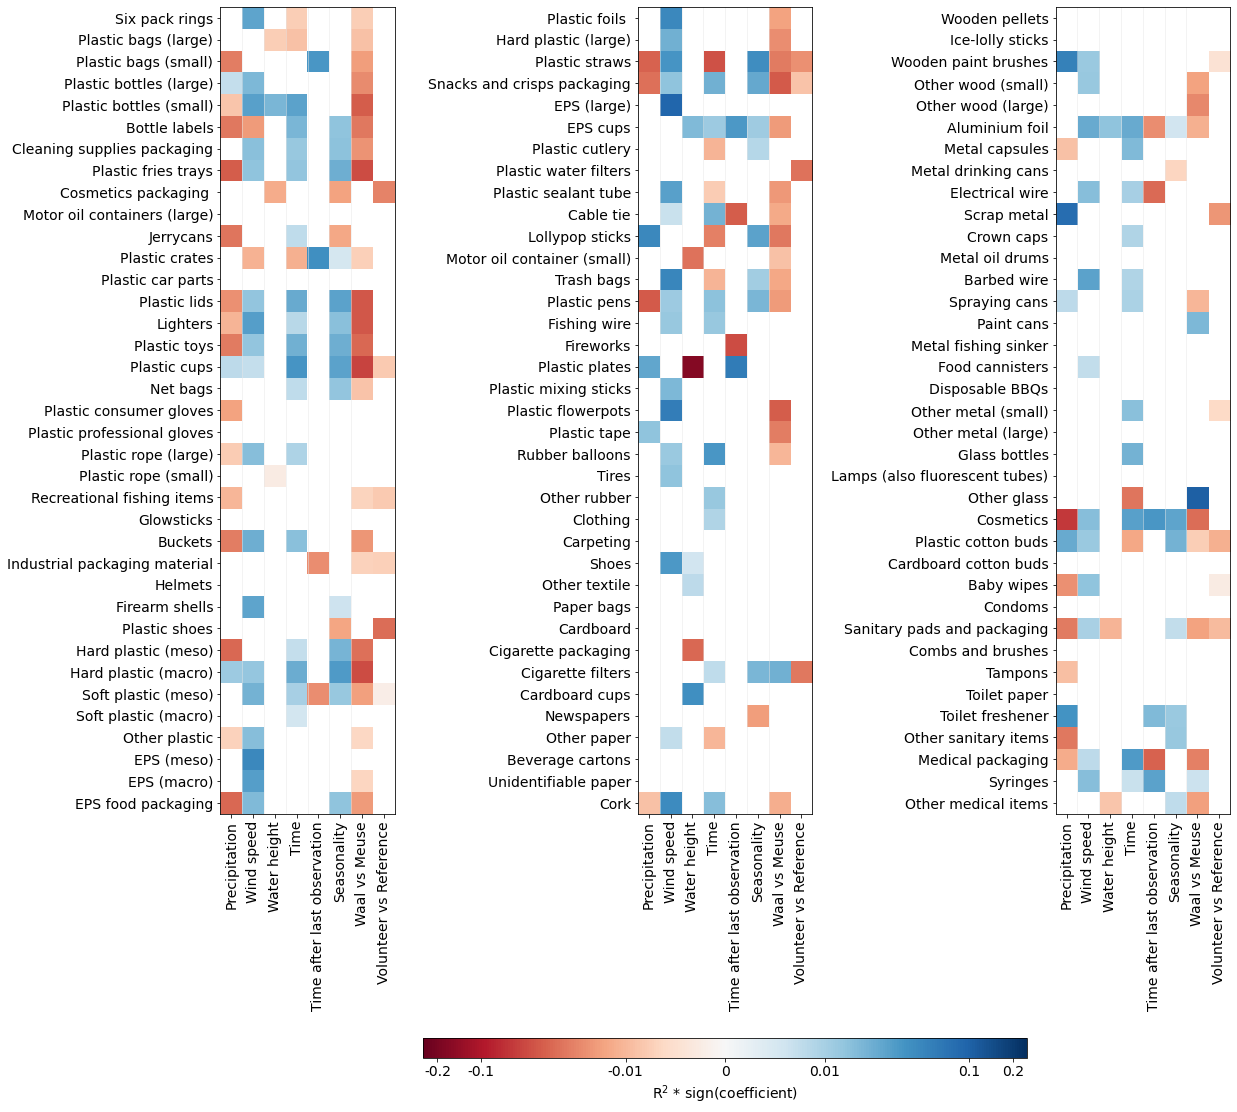

In [12]:
f, ax = plt.subplots(ncols=3, figsize=(26, 20))
ax = ax.flatten()
norm = SymLogNorm(linthresh=0.01, vmin=-0.25, vmax=0.25)
cmap = "RdBu"
for i in range(3):
    idx = np.s_[i*37:(i+1)*37]
    ax[i].imshow(x.iloc[idx, :-1], cmap=cmap, norm=norm, origin='upper')
    ax[i].set_xticks(np.arange(0, 8))
    ax[i].set_xticklabels([titles[i] for i in list(x.columns)[:-1]], rotation=90)
    ax[i].set_yticks(np.arange(0, 37))
    ax[i].set_yticklabels(list(x.name.values)[idx])
    for ii in range(7):
        ax[i].axvline(ii-0.5, color=(0.9, 0.9, 0.9, 0.6), linewidth=0.8)
    
plt.tight_layout(w_pad=-36)
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation="horizontal",
             pad=0.185, aspect=30, shrink=0.35)
cbar.set_ticks([-0.2, -0.1, -0.01, 0, 0.01, 0.1, 0.2])
cbar.set_ticklabels([-0.2, -0.1, -0.01, 0, 0.01, 0.1, 0.2])
cbar.set_label(r"R$\rm^{2}$ * sign(coefficient)")
plt.savefig("figures/coefficient_table.png", bbox_inches='tight', dpi=300)
plt.show()

### Christmas tree

In [13]:
df_items = multi_param_r.copy()
df_items.index = translations.loc[df_items.index, "Name"].values
df_items.columns = ['r', 'sd']
df_items.loc[:, 'threshold'] = df_items.r - df_items.sd * 2.3
df_items = df_items.loc[df_items.threshold < 0, :].sort_values("r").append(df_items.loc[df_items.threshold >= 0, :].sort_values("r"))
df_items.loc[:, "color"] = df_items.apply(lambda x: "#5ab4ac" if x.threshold >= 0 else "#d8b365", axis=1)

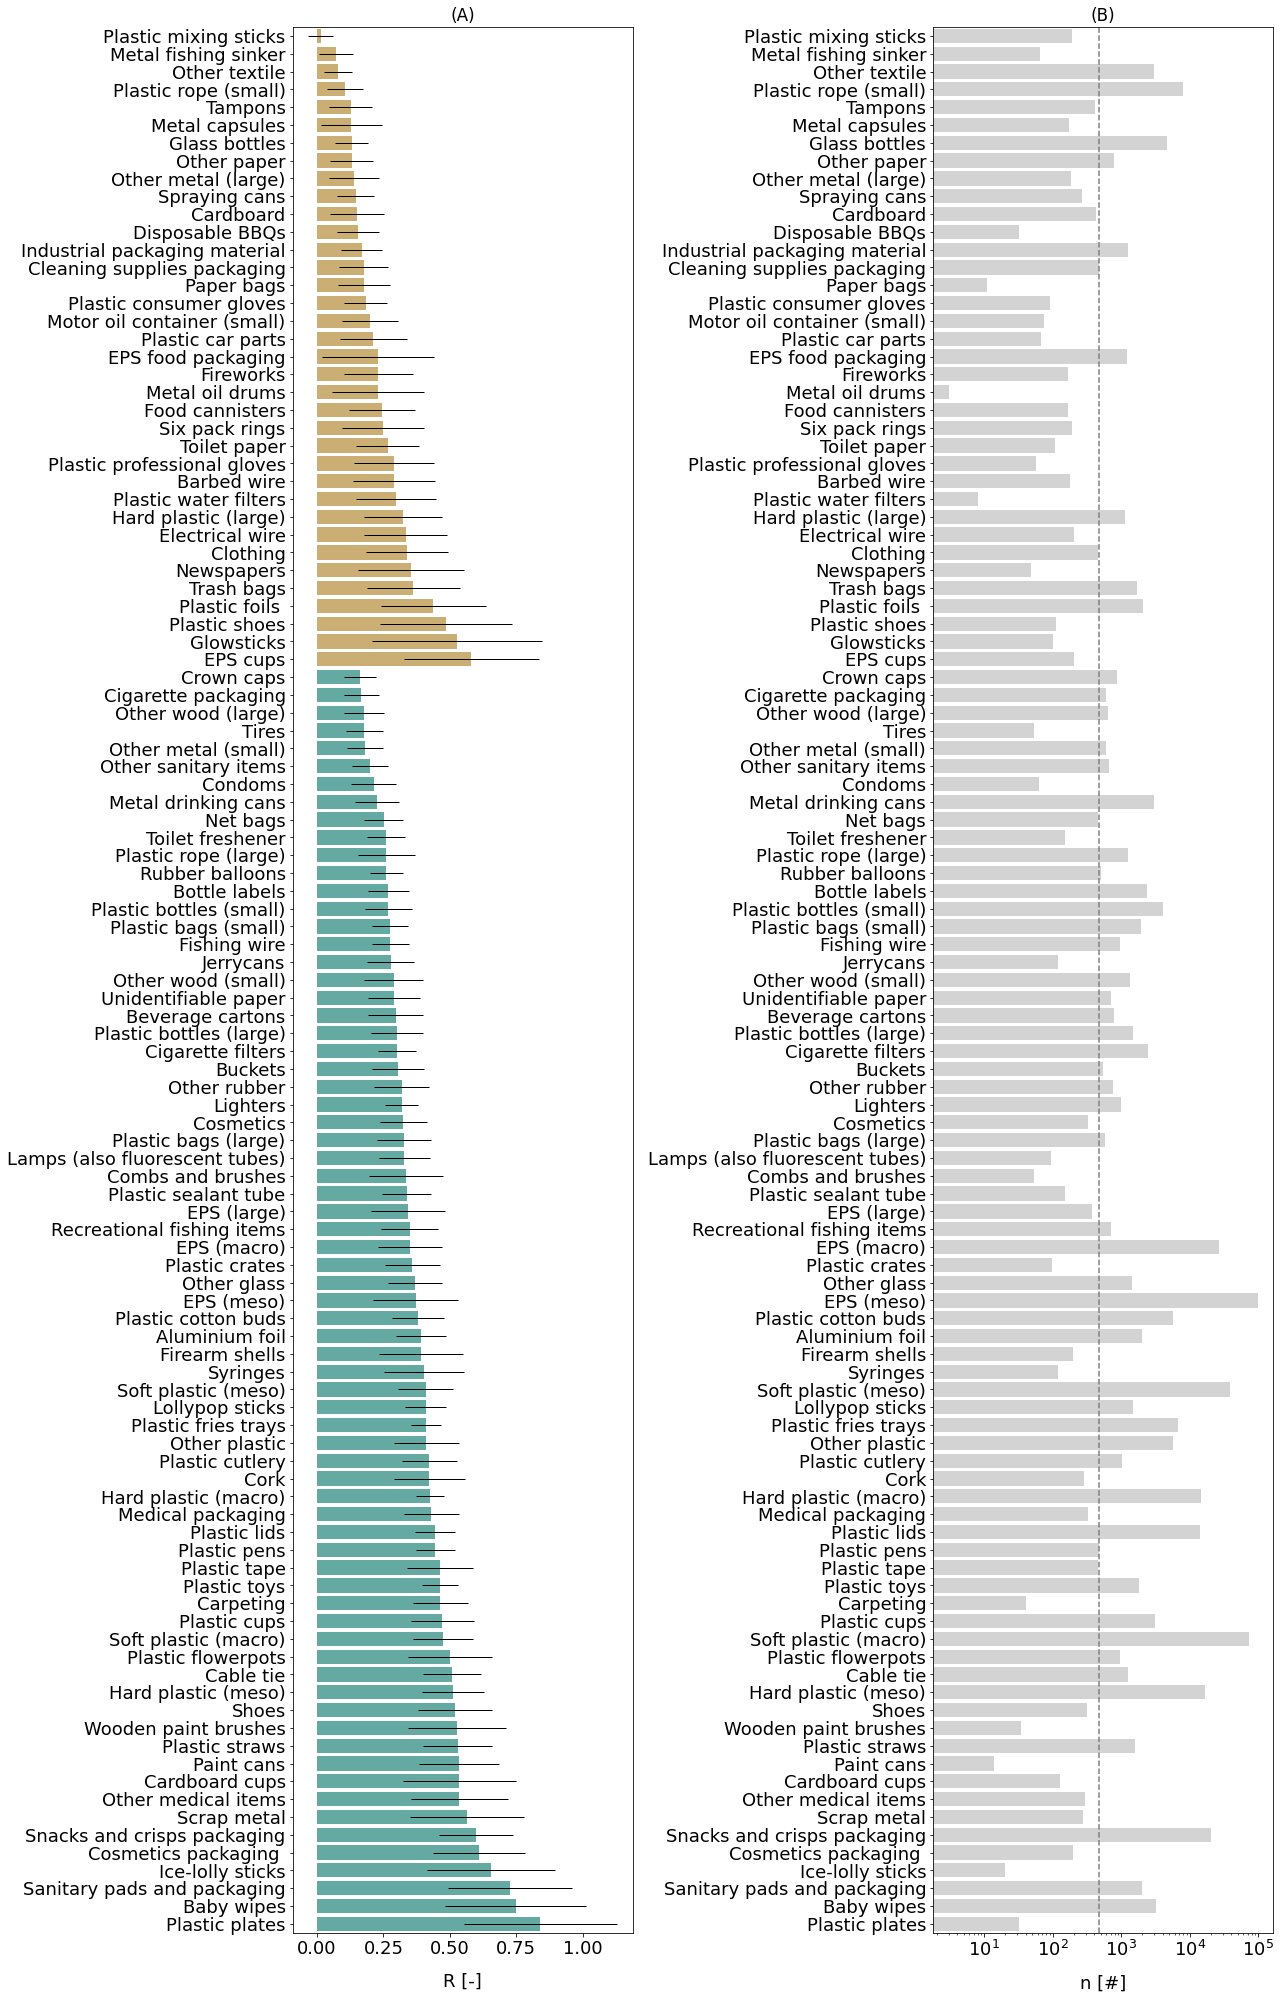

In [14]:
f, ax = plt.subplots(ncols=2, figsize=(18, 28))
ax = ax.flatten()
sns.barplot(data=df_items, x="r", y=df_items.index, ci="None", ax=ax[0], palette=df_items.color)
ylim = ax[0].get_ylim()
ax[0].errorbar(x=df_items.r, y=df_items.index, fmt='none', xerr=df_items.sd, ecolor='k', elinewidth=1)
ax[0].set_ylim(ylim)

count = pd.DataFrame(df.loc[:, ITEMS].sum(), columns=['n'])
count.index = translations.loc[count.index, "Name"].values
count = count.loc[df_items.index, :]
sns.barplot(data=count, x='n', y=count.index, color='lightgrey', ax=ax[1])
ax[1].set_xscale('log')
ax[1].axvline(count.median()[0], color='grey', linestyle='--')

ax[0].set_title("(A)")
ax[1].set_title("(B)")
ax[0].set_xlabel("R [-]", fontsize=18, labelpad=15)
ax[1].set_xlabel("n [#]", fontsize=18, labelpad=15)

ax[0].tick_params(labelsize=18)
ax[1].tick_params(labelsize=18)

plt.tight_layout()
plt.savefig("figures/multi_parameter_r.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
cmap = cmap_from_borders(colors=['White', 'Darkblue'])

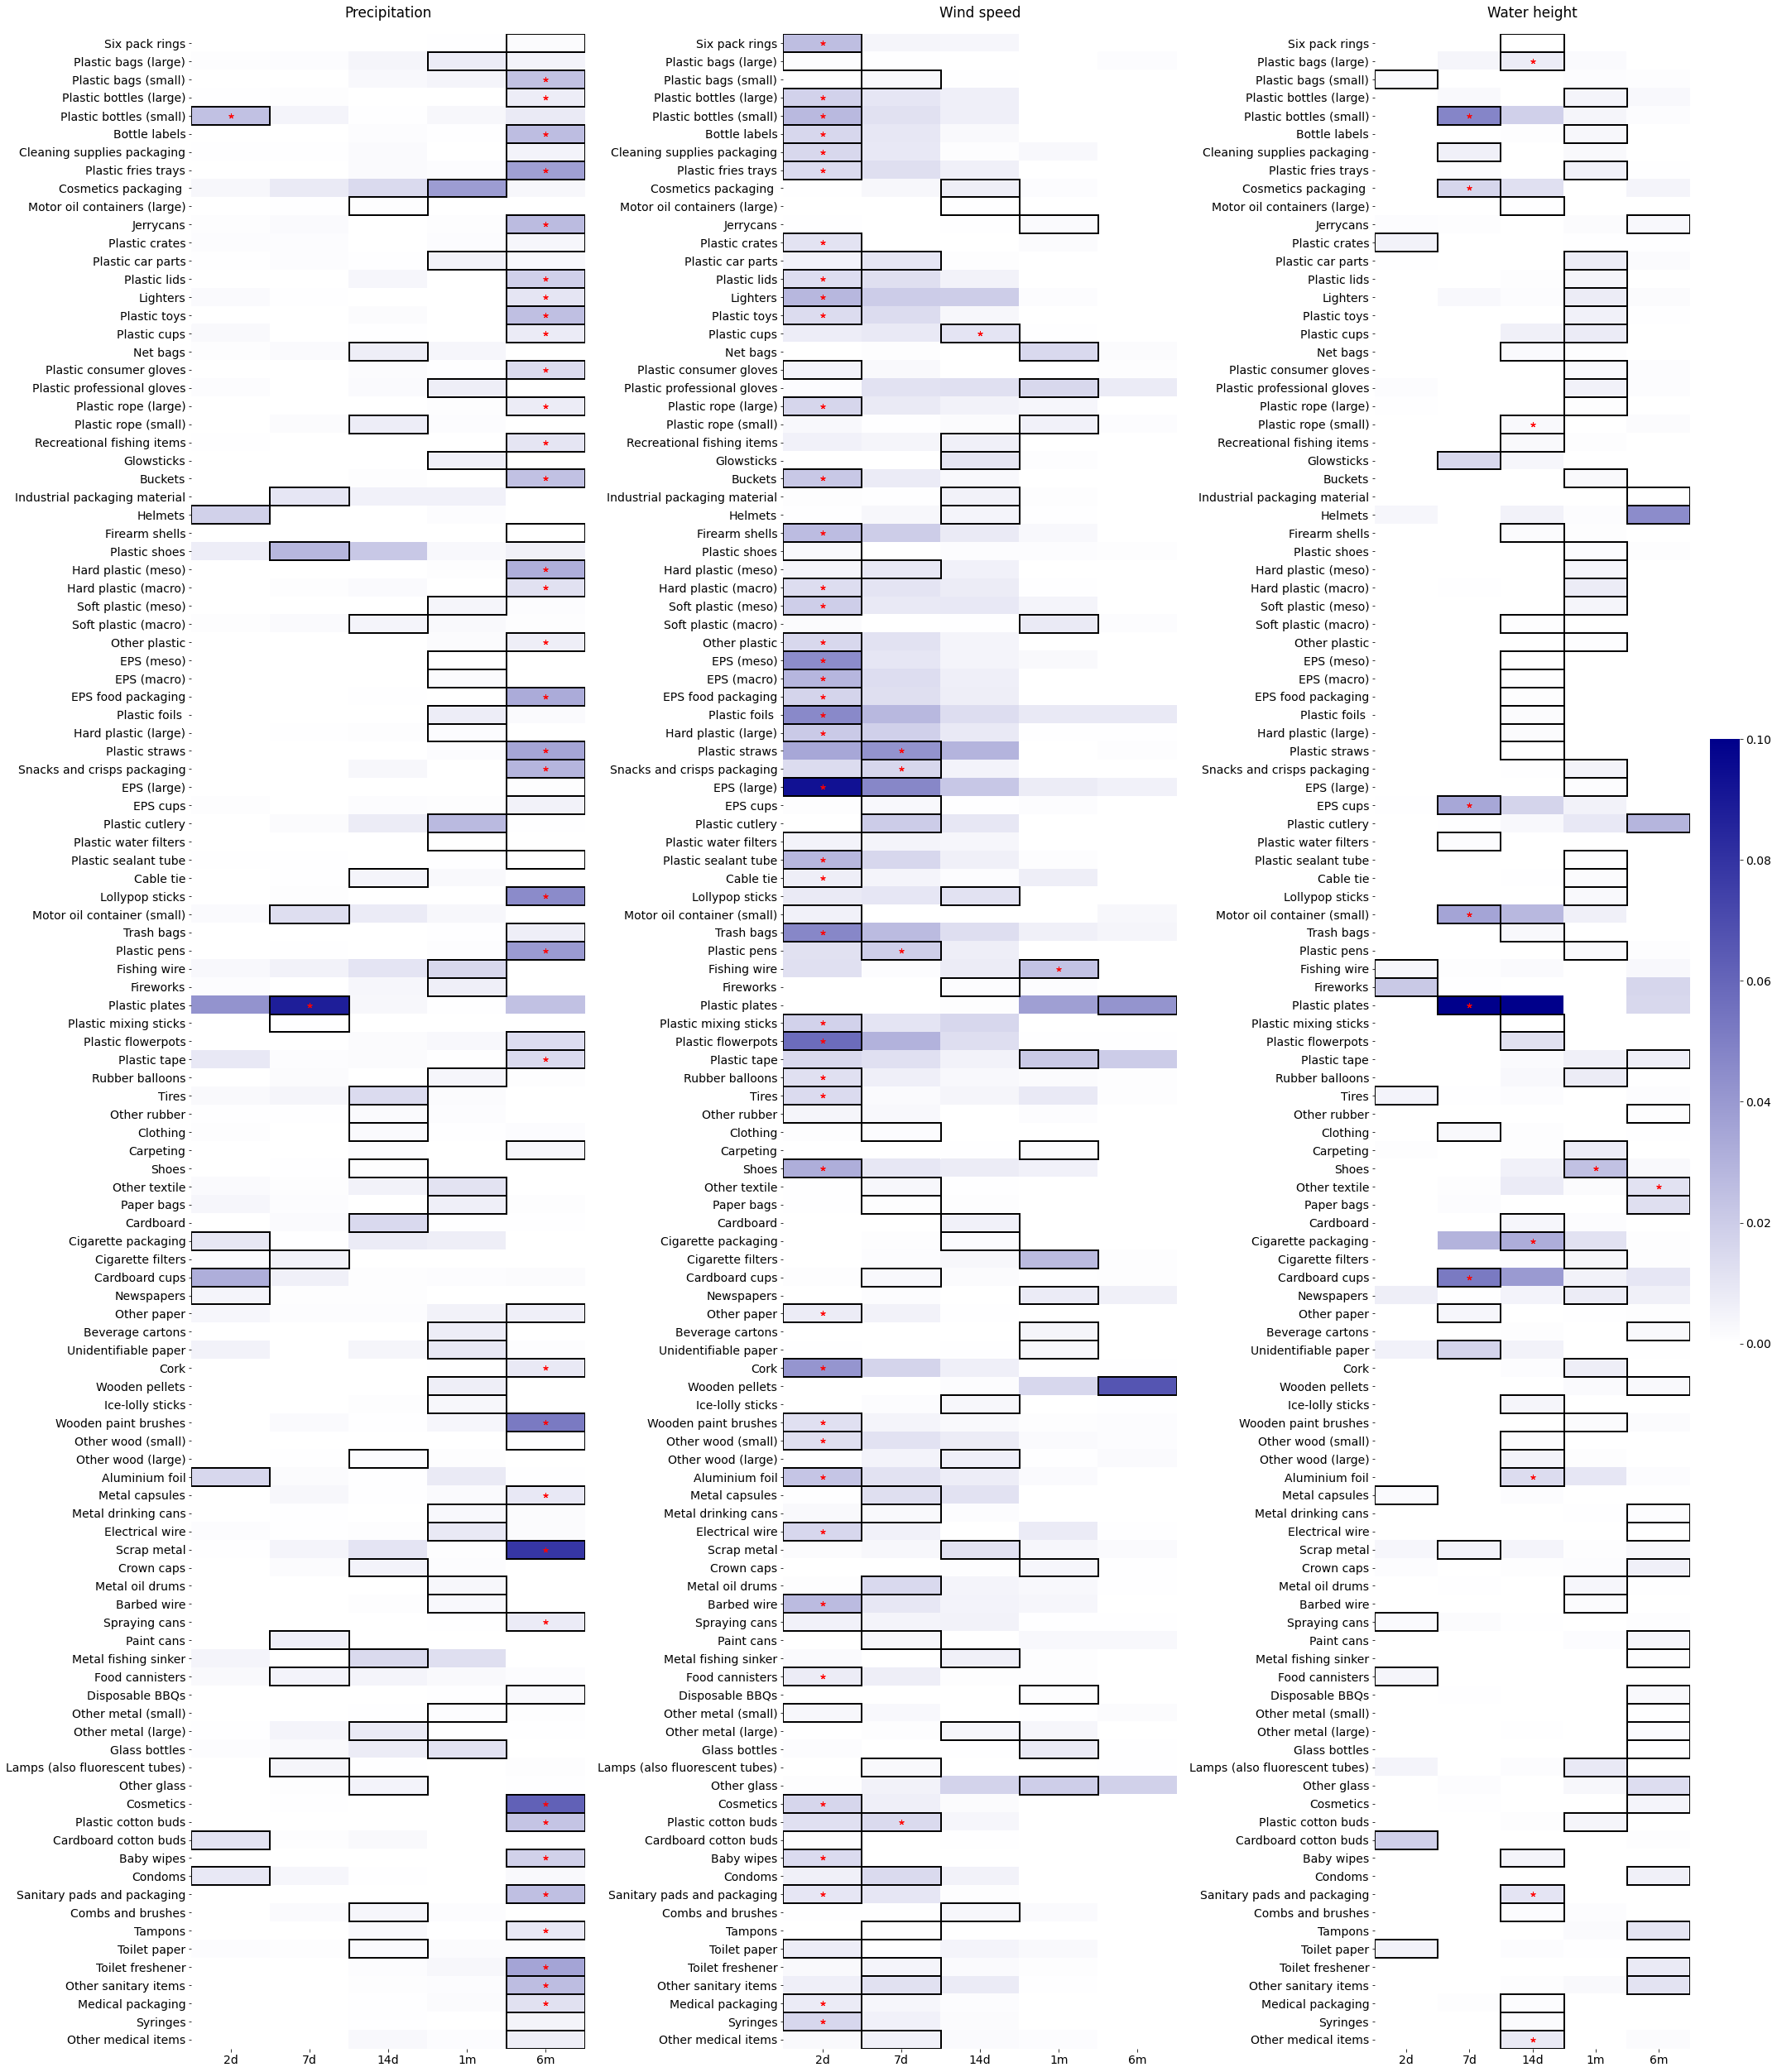

In [16]:
f, ax = plt.subplots(ncols=3, figsize=(30, 35))
ax=ax.flatten()

sns.heatmap(precipitation_r2, vmin=0, vmax=0.1, cmap=cmap, ax=ax[0], cbar=False)
ax[0].set_yticklabels(translations.loc[precipitation_r2.index, "Name"].values.tolist())
for i, row in precipitation_r2.reset_index(drop=True).iterrows():
    rect = patches.Rectangle((np.argmax(row), i), 1, 1, facecolor='none', edgecolor='black', linewidth=2)
    ax[0].add_patch(rect)
    if performance.iloc[i, 0] > 0.9:
        ax[0].plot(np.argmax(row)+0.5, i+0.5, color='Red', marker=(5, 2))
ax[0].set_title("Precipitation", pad=20)
        
sns.heatmap(wind_r2, vmin=0, vmax=0.1, cmap=cmap, ax=ax[1], cbar=False)
ax[1].set_yticklabels(translations.loc[wind_r2.index, "Name"].values.tolist())
for i, row in wind_r2.reset_index(drop=True).iterrows():
    rect = patches.Rectangle((np.argmax(row), i), 1, 1, facecolor='none', edgecolor='black', linewidth=2)
    ax[1].add_patch(rect)
    if performance.iloc[i, 1] > 0.9:
        ax[1].plot(np.argmax(row)+0.5, i+0.5, color='Red', marker=(5, 2))
ax[1].set_title("Wind speed", pad=20)
    
sns.heatmap(discharge_r2, vmin=0, vmax=0.1, cmap=cmap, ax=ax[2], cbar_kws={"shrink": 0.3})
ax[2].set_yticklabels(translations.loc[discharge_r2.index, "Name"].values.tolist())
for i, row in discharge_r2.reset_index(drop=True).iterrows():
    rect = patches.Rectangle((np.argmax(row), i), 1, 1, facecolor='none', edgecolor='black', linewidth=2)
    ax[2].add_patch(rect)
    if performance.iloc[i, 2] > 0.9:
        ax[2].plot(np.argmax(row)+0.5, i+0.5, color='Red', marker=(5, 2))
ax[2].set_title("Water height", pad=20)        
        
plt.tight_layout()
plt.savefig("figures/lag_time.png", dpi=300, bbox_inches='tight')
plt.show()

## Significantly explained

In [17]:
df_items.loc[:, "explained_items"] = (df_items.r ** 2) * count.n

Capability of predicting all items

In [18]:
print(f"without r2: \t{(count.loc[df_items.threshold >= 0, 'n'].sum() / count.sum())[0]}")
print(f"wit r2: \t{(df_items.loc[df_items.threshold >= 0, 'explained_items'].sum() / count.sum())[0]}")

without r2: 	0.9291489340346087
wit r2: 	0.17042714547309584


Capability of predicting only objects

In [19]:
objects = translations.loc[[item for item in ITEMS if "0_2_5" not in item and \
                            "helmen" not in item and \
                            "granulaat" not in item], "Name"].values

count_select = count.loc[count.index.intersection(objects), :]
df_items_select = df_items.loc[df_items.index.intersection(objects), :]

In [20]:
print(f"without r2: \t{(count_select.loc[df_items_select.threshold >= 0, 'n'].sum() / count_select.sum())[0]}")
print(f"wit r2: \t{(df_items_select.loc[df_items_select.threshold >= 0, 'explained_items'].sum() / count_select.sum())[0]}")

without r2: 	0.885697514371306
wit r2: 	0.17783872613496374


In [21]:
# items at least explained by 1 hydrometeorology
(x.loc[:, ["P", "U", "Q"]].isna().sum(axis=1) < 3).sum()

72

In [22]:
# items explained by at least one parameter
(x.loc[:, parameters].isna().sum(axis=1) < 8).sum()

90